In [33]:
import os
import gc
import optuna
import warnings
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
warnings.filterwarnings('ignore')
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [34]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [35]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)
        df_['based_on_tr'] = df_['location'].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

df = fix_location(df)

skills_df = load_skills(config.skills_path, 60)
lang_df = load_languages(config.languages_path, 10)
edu_df = load_education(config.education_path, 21, 15)
exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

df['nunique_company_by_industries'] = df.groupby(by = 'industry')['company_id'].transform('nunique')

#df['employee_total_last_exp_diff'] = df['employee_total_experience'] - df['employee_last_experience']

#df['nunique_employees_by_industries'] = df.groupby(by = 'industry')['user_id'].transform('nunique')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 320842


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


(66274, 124)


,user_id,industry,location,moved_after_2019,based_on_tr,skill_Java,skill_JavaScript,skill_C#,skill_SQL,skill_Software Development,...,degree_Licentiate degree,degree_Bachelor of Applied Science,employee_lifetime,employee_last_experience,employee_total_experience,nunique_company,employee_avg_days_to_quit,company_id,company_avg_days_to_quit,nunique_company_by_industries
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1341.0,306.0,1035.0,3.0,447.000000,26.0,912.280537,3260.0
1,6950,Internet,ISTANBUL,0.0,1,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,2101.0,699.0,1402.0,4.0,525.250000,1337.0,393.769231,743.0
2,4880,Online Media,TURKEY,0.0,1,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1826.0,610.0,1216.0,4.0,456.500000,4366.0,NaN,32.0
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3409.0,1553.0,1856.0,1.0,3409.000000,26.0,912.280537,660.0
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3409.0,640.0,2769.0,3.0,1136.333333,1562.0,837.166667,424.0


In [36]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 123)
test_set: (13255, 123)


## XGBoost

In [37]:
xgb_params = {'max_depth': 12,
              'subsample': 0.8,
              #'eta': 0.02,
              #'reg_alpha': 2,
              #'reg_lambda': 24,
              'learning_rate': 0.01
              }

#xgb_params['eval_metric'] = 'accuracy'
xgb_params['enable_categorical'] = True
xgb_params['random_state'] = config.seed
xgb_params['tree_method'] = 'hist'
xgb_params['n_estimators'] = 5000

-----------------------------------| Fold 1 |-----------------------------------
[0]	validation_0-logloss:0.69119
[200]	validation_0-logloss:0.56680
[400]	validation_0-logloss:0.54100
[600]	validation_0-logloss:0.52416
[800]	validation_0-logloss:0.51086
[1000]	validation_0-logloss:0.49984
[1200]	validation_0-logloss:0.48992
[1400]	validation_0-logloss:0.48183
[1600]	validation_0-logloss:0.47534
[1800]	validation_0-logloss:0.46972
[2000]	validation_0-logloss:0.46534
[2200]	validation_0-logloss:0.46207
[2400]	validation_0-logloss:0.45921
[2600]	validation_0-logloss:0.45716
[2800]	validation_0-logloss:0.45567
[3000]	validation_0-logloss:0.45471
[3200]	validation_0-logloss:0.45411
[3400]	validation_0-logloss:0.45408
[3600]	validation_0-logloss:0.45457
[3704]	validation_0-logloss:0.45478


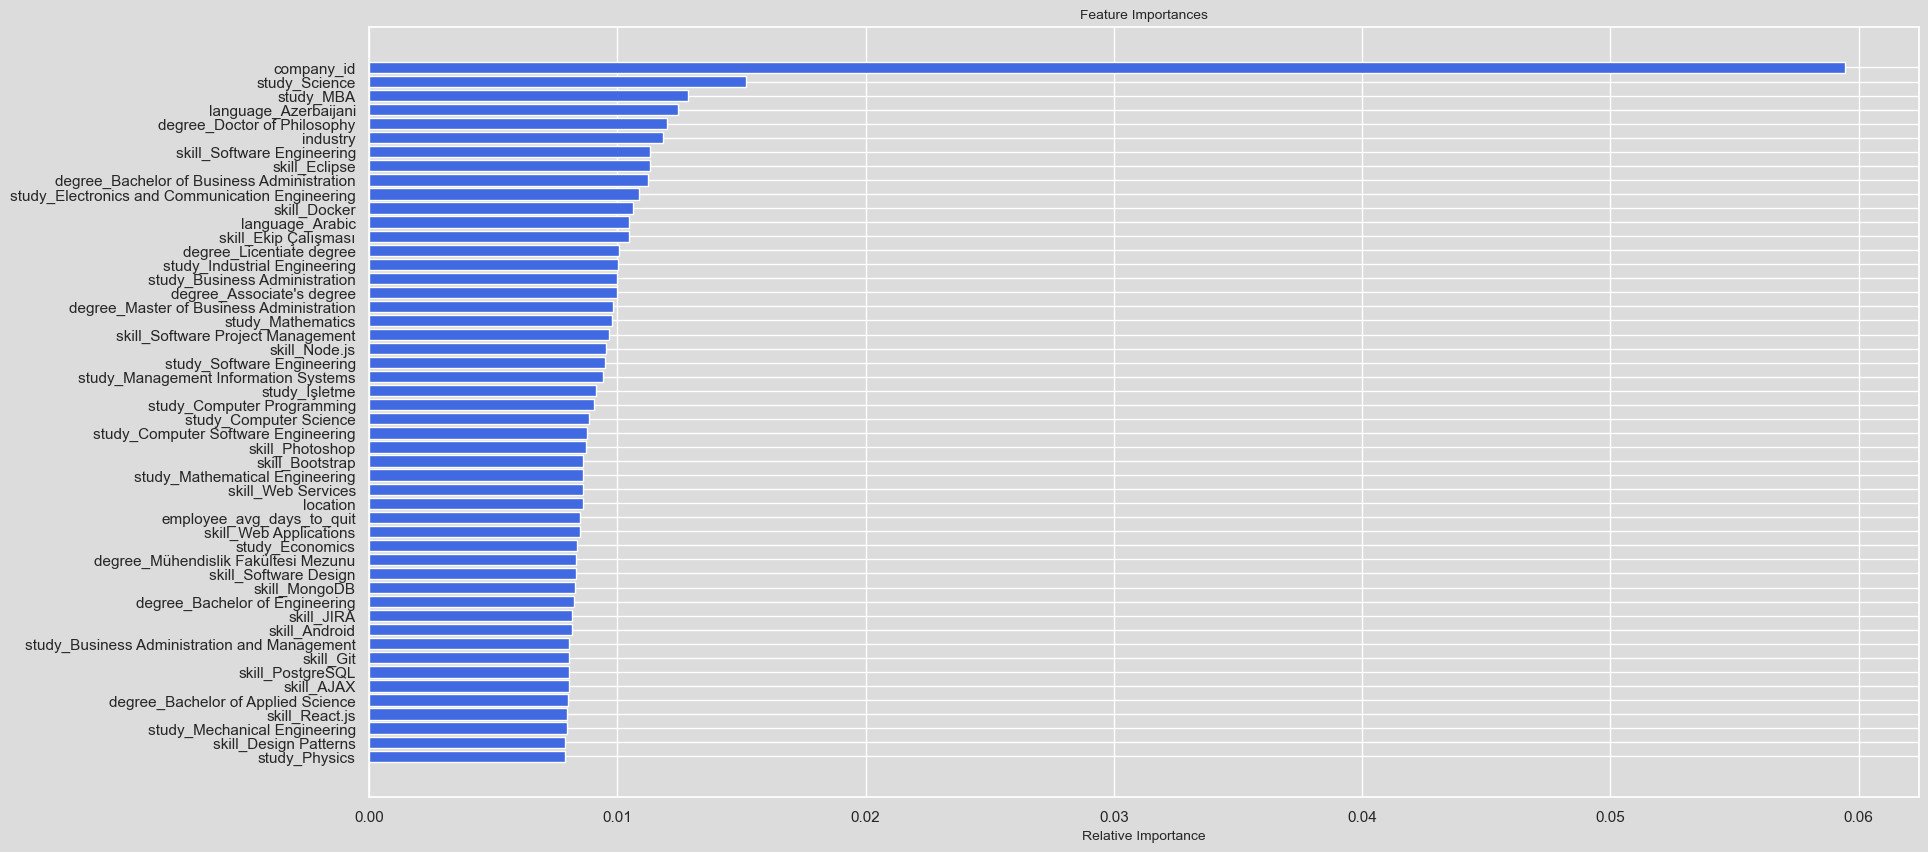

fold accuracy: 0.7797895213307684
-----------------------------------| Fold 2 |-----------------------------------
[0]	validation_0-logloss:0.69112
[200]	validation_0-logloss:0.56304
[400]	validation_0-logloss:0.53741
[600]	validation_0-logloss:0.52149
[800]	validation_0-logloss:0.50855
[1000]	validation_0-logloss:0.49746
[1200]	validation_0-logloss:0.48806
[1400]	validation_0-logloss:0.48052
[1600]	validation_0-logloss:0.47354
[1800]	validation_0-logloss:0.46815
[2000]	validation_0-logloss:0.46366
[2200]	validation_0-logloss:0.46037
[2400]	validation_0-logloss:0.45829
[2600]	validation_0-logloss:0.45629
[2800]	validation_0-logloss:0.45450
[3000]	validation_0-logloss:0.45329
[3200]	validation_0-logloss:0.45270
[3400]	validation_0-logloss:0.45252
[3600]	validation_0-logloss:0.45276
[3766]	validation_0-logloss:0.45334


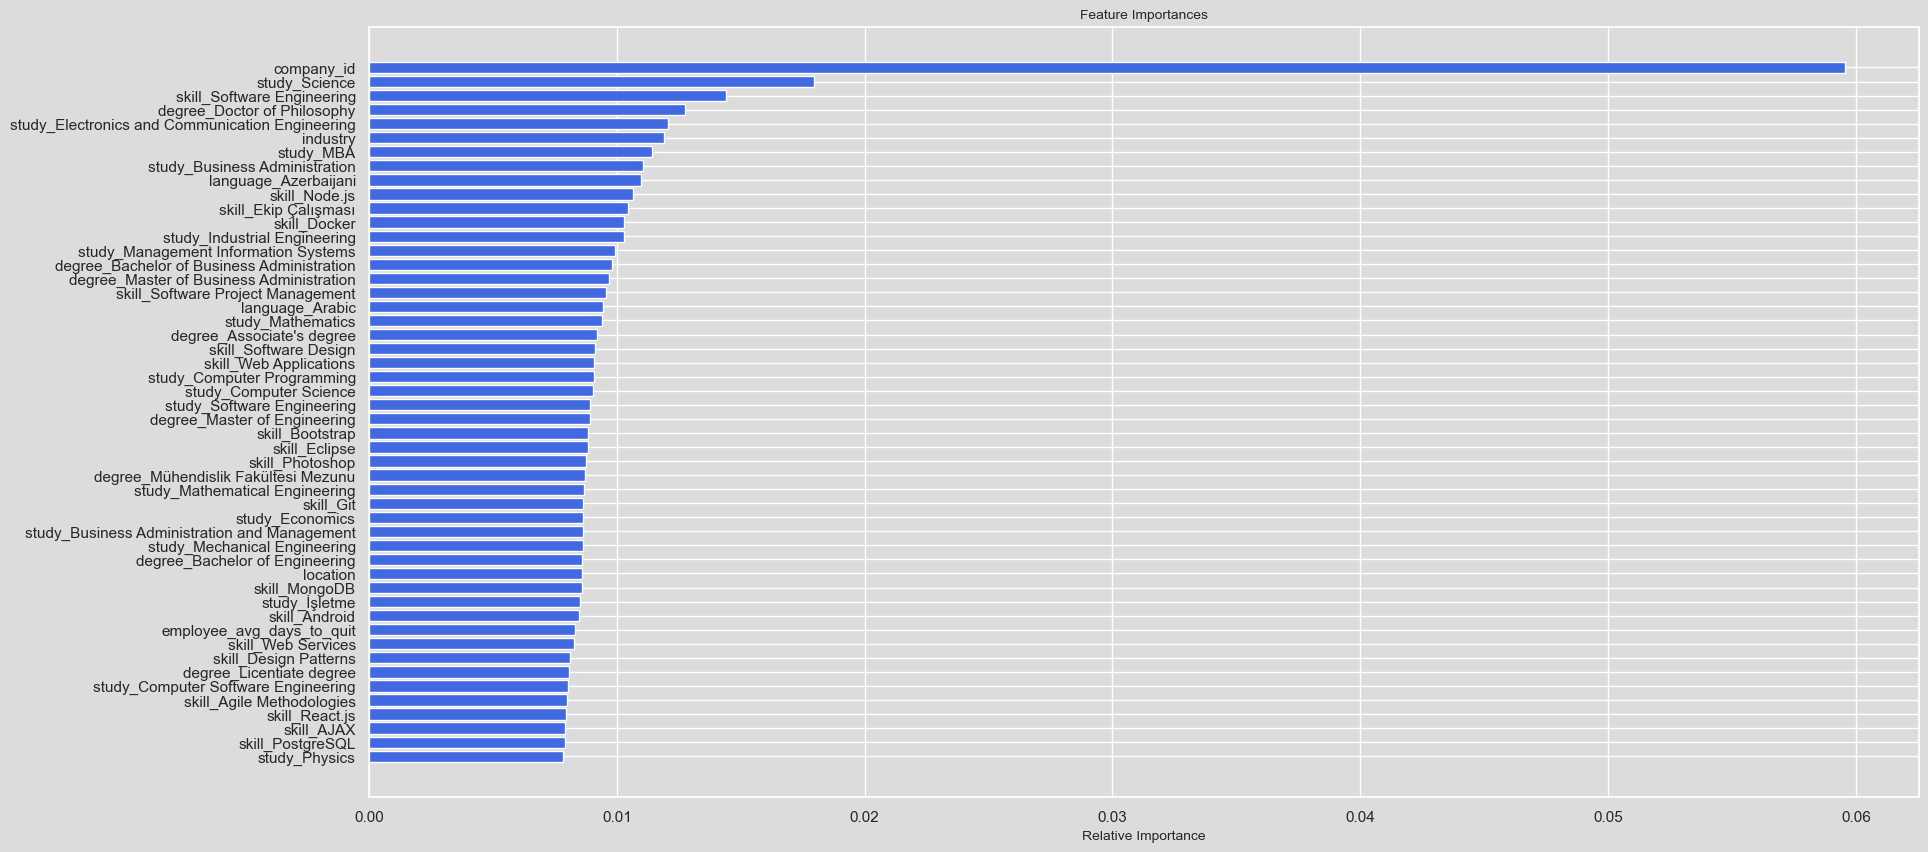

fold accuracy: 0.7848817471992757
-----------------------------------| Fold 3 |-----------------------------------
[0]	validation_0-logloss:0.69114
[200]	validation_0-logloss:0.56392
[400]	validation_0-logloss:0.53985
[600]	validation_0-logloss:0.52291
[800]	validation_0-logloss:0.50944
[1000]	validation_0-logloss:0.49821
[1200]	validation_0-logloss:0.48862
[1400]	validation_0-logloss:0.48093
[1600]	validation_0-logloss:0.47460
[1800]	validation_0-logloss:0.46946
[2000]	validation_0-logloss:0.46575
[2200]	validation_0-logloss:0.46256
[2400]	validation_0-logloss:0.46015
[2600]	validation_0-logloss:0.45883
[2800]	validation_0-logloss:0.45841
[3000]	validation_0-logloss:0.45823
[3200]	validation_0-logloss:0.45851
[3400]	validation_0-logloss:0.45911
[3461]	validation_0-logloss:0.45937


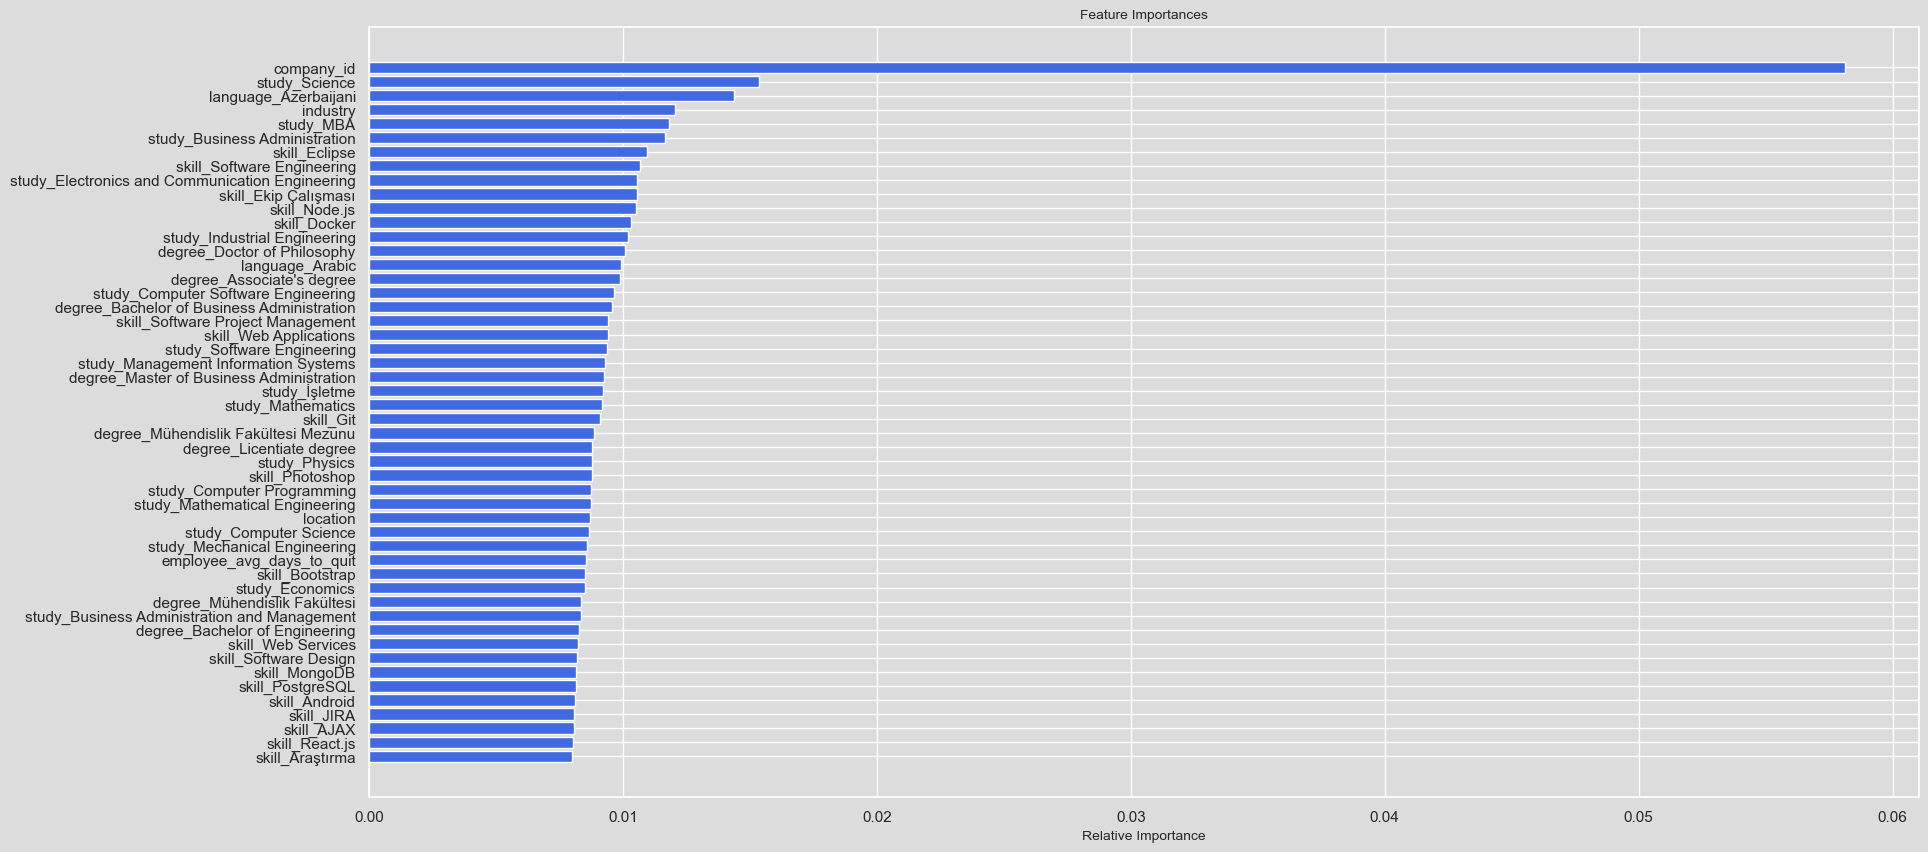

fold accuracy: 0.7829580174267285
-----------------------------------| Fold 4 |-----------------------------------
[0]	validation_0-logloss:0.69118
[200]	validation_0-logloss:0.56522
[400]	validation_0-logloss:0.54001
[600]	validation_0-logloss:0.52311
[800]	validation_0-logloss:0.51028
[1000]	validation_0-logloss:0.49929
[1200]	validation_0-logloss:0.48975
[1400]	validation_0-logloss:0.48159
[1600]	validation_0-logloss:0.47530
[1800]	validation_0-logloss:0.46979
[2000]	validation_0-logloss:0.46527
[2200]	validation_0-logloss:0.46200
[2400]	validation_0-logloss:0.45957
[2600]	validation_0-logloss:0.45775
[2800]	validation_0-logloss:0.45679
[3000]	validation_0-logloss:0.45622
[3200]	validation_0-logloss:0.45597
[3400]	validation_0-logloss:0.45607
[3600]	validation_0-logloss:0.45676
[3707]	validation_0-logloss:0.45719


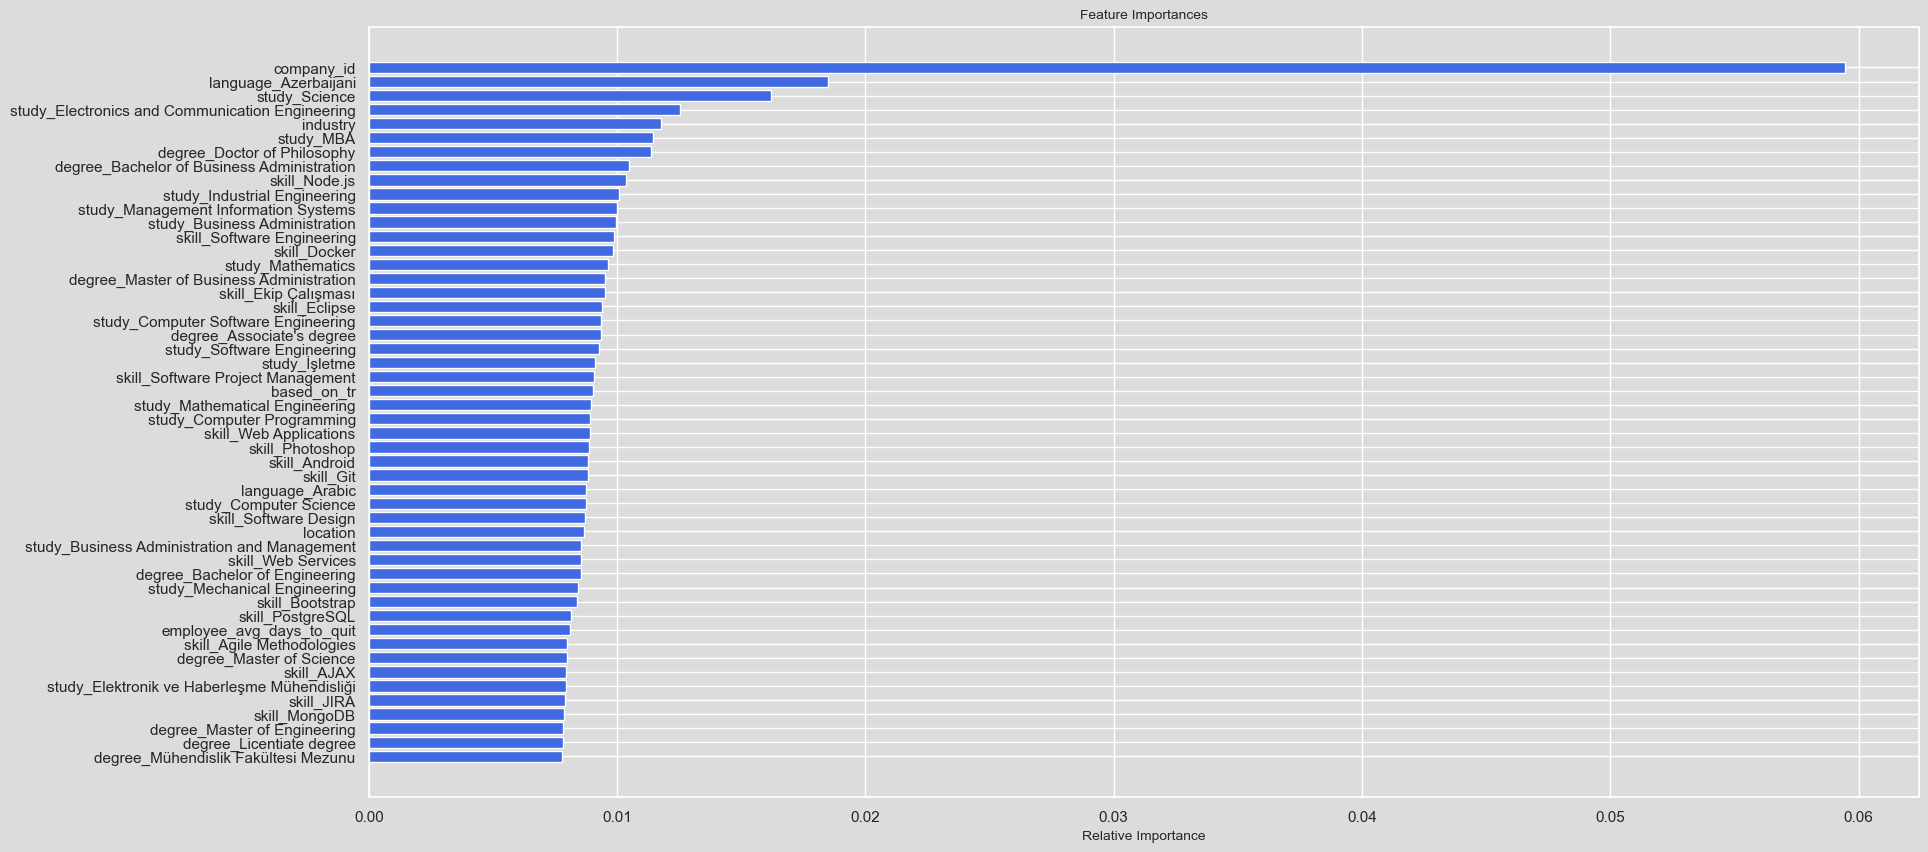

fold accuracy: 0.7786328655500226
-----------------------------------| Fold 5 |-----------------------------------
[0]	validation_0-logloss:0.69110
[200]	validation_0-logloss:0.55909
[400]	validation_0-logloss:0.53237
[600]	validation_0-logloss:0.51548
[800]	validation_0-logloss:0.50240
[1000]	validation_0-logloss:0.49142
[1200]	validation_0-logloss:0.48156
[1400]	validation_0-logloss:0.47351
[1600]	validation_0-logloss:0.46652
[1800]	validation_0-logloss:0.46040
[2000]	validation_0-logloss:0.45607
[2200]	validation_0-logloss:0.45247
[2400]	validation_0-logloss:0.44978
[2600]	validation_0-logloss:0.44759
[2800]	validation_0-logloss:0.44649
[3000]	validation_0-logloss:0.44546
[3200]	validation_0-logloss:0.44520
[3400]	validation_0-logloss:0.44518
[3600]	validation_0-logloss:0.44554
[3722]	validation_0-logloss:0.44600


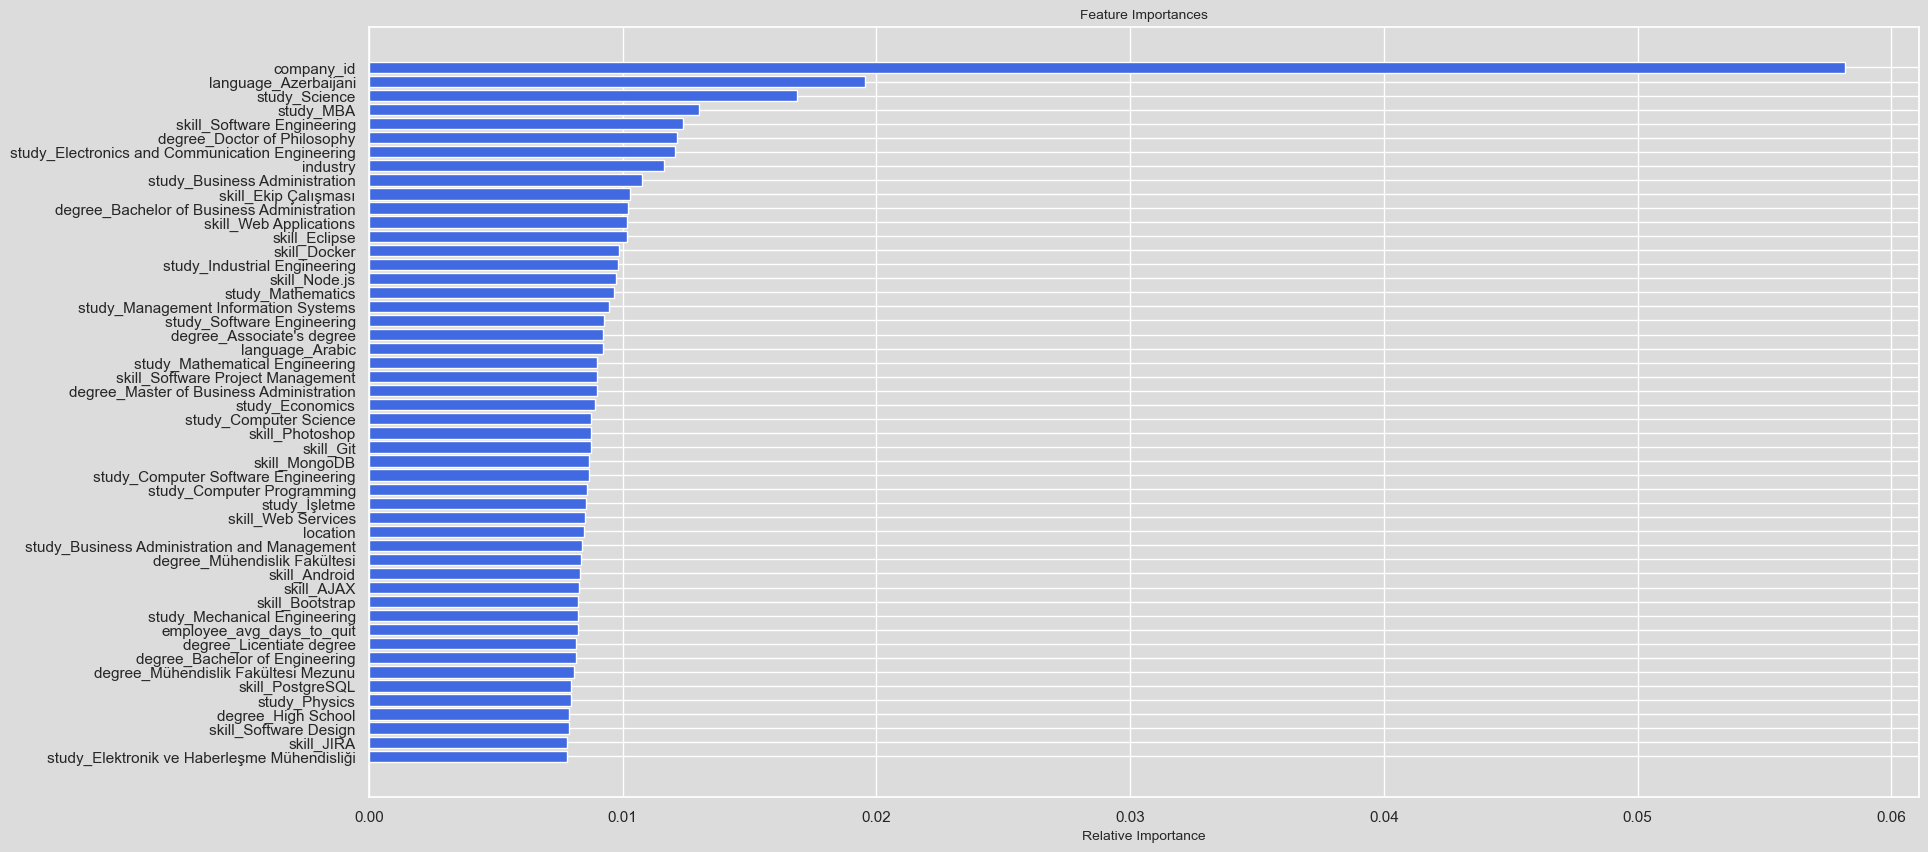

fold accuracy: 0.7851969216840199
-----------------------------------| Fold 6 |-----------------------------------
[0]	validation_0-logloss:0.69117
[200]	validation_0-logloss:0.56656
[400]	validation_0-logloss:0.54173
[600]	validation_0-logloss:0.52495
[800]	validation_0-logloss:0.51179
[1000]	validation_0-logloss:0.50099
[1200]	validation_0-logloss:0.49192
[1400]	validation_0-logloss:0.48439
[1600]	validation_0-logloss:0.47801
[1800]	validation_0-logloss:0.47292
[2000]	validation_0-logloss:0.46868
[2200]	validation_0-logloss:0.46603
[2400]	validation_0-logloss:0.46395
[2600]	validation_0-logloss:0.46224
[2800]	validation_0-logloss:0.46154
[3000]	validation_0-logloss:0.46098
[3200]	validation_0-logloss:0.46087
[3400]	validation_0-logloss:0.46108
[3576]	validation_0-logloss:0.46149


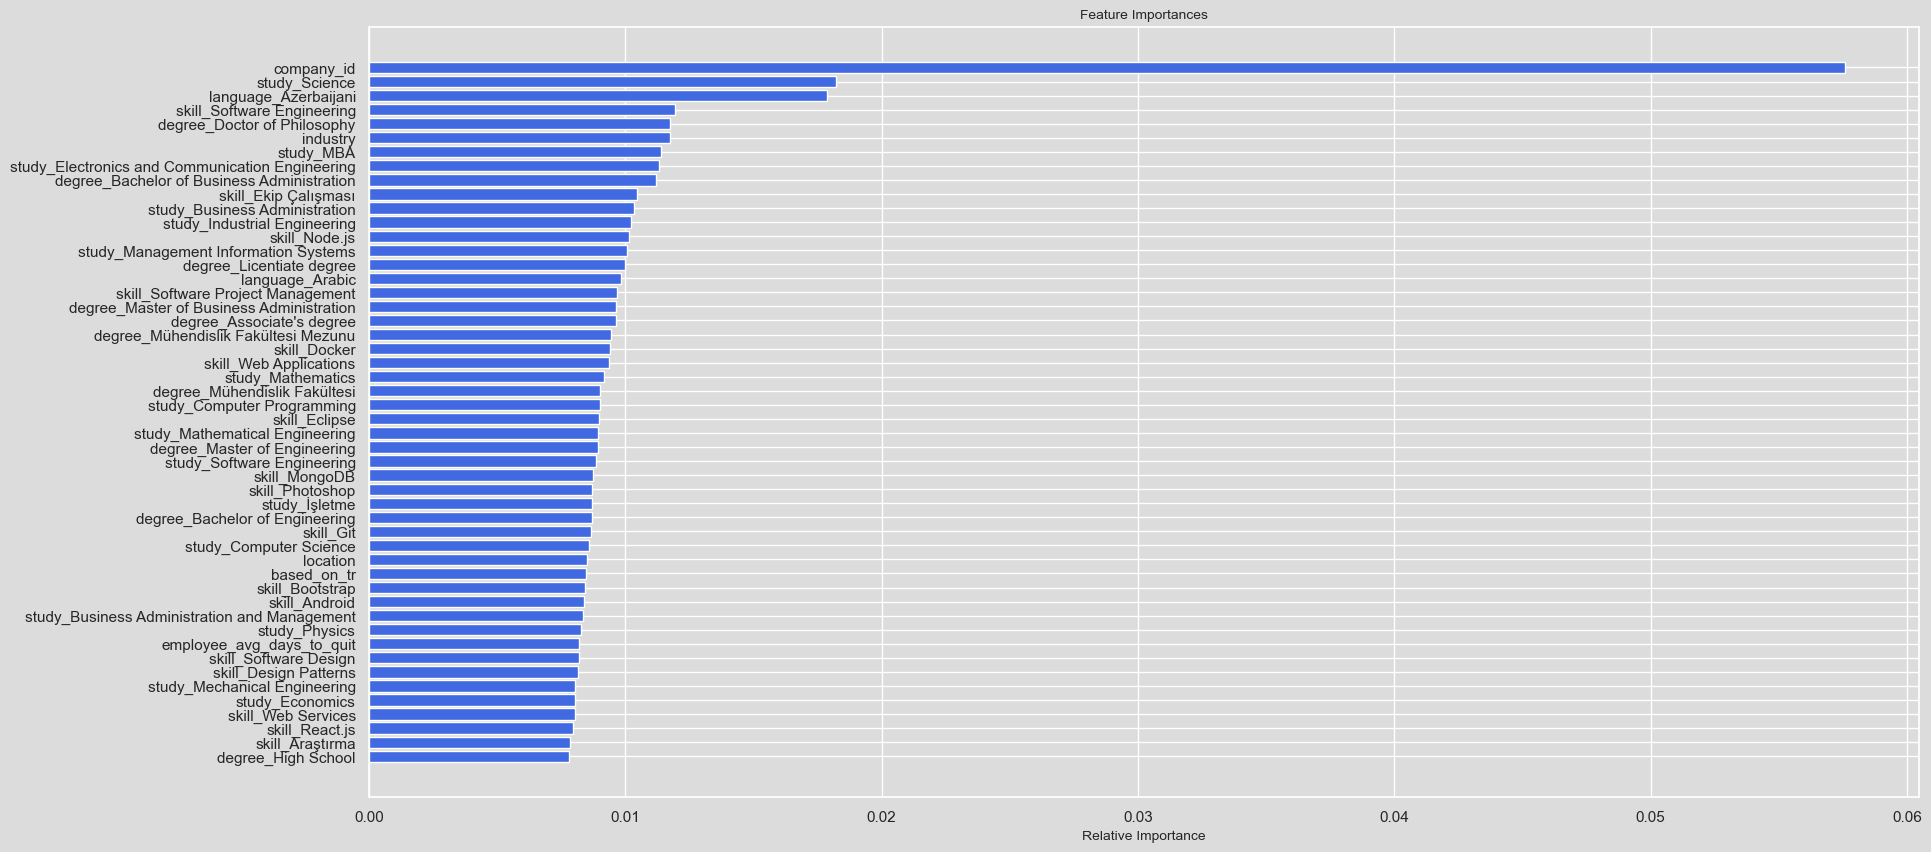

fold accuracy: 0.7834993209597103
accuracy: 0.7824930685226051
folds avg accuracy: 0.7824930656917543


In [38]:
kf = KFold(n_splits=config.n_folds)

X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

scores = list()
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    #model = CatBoostClassifier(**params)
    model = XGBClassifier(**xgb_params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds = 400,
        verbose = 200
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    scores.append(accuracy_score(y_val, val_pred))
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')
print(f'folds avg accuracy: {np.mean(scores)}')

In [39]:
#sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

#sub.head()

In [40]:
#sub.to_csv(f'../submissions/submission{round(val_score, 6)}.csv', index = False)

In [41]:
#from sklearn.ensemble import VotingClassifier
#
#cat_params = {'one_hot_max_size': 156,
#              'depth': 12,
#              'boosting_type': 'Plain',
#              'bootstrap_type': 'MVS'}
#
#cat_params["iterations"] = 2500
##cat_params["early_stopping_rounds"] = 400
#cat_params['random_state'] = config.seed
#cat_params['cat_features'] = cat_features
#cat_params['eval_metric'] = 'Accuracy'
#cat_params['allow_writing_files'] = False
#cat_params['verbose'] = False
#
#xgb_params = {'max_depth': 12,
#              'subsample': 0.8,
#              'learning_rate': 0.01}
#
##xgb_params["early_stopping_rounds"] = 400
#xgb_params['enable_categorical'] = True
#xgb_params['random_state'] = config.seed
#xgb_params['tree_method'] = 'hist'
#xgb_params['n_estimators'] = 2500
#
#cat = CatBoostClassifier(**cat_params)
#xgb = XGBClassifier(**xgb_params)


In [42]:
#kf = KFold(n_splits=config.n_folds)
#
#X = train_set.drop(columns=[target], axis=1)
#y = train_set[target]
#features = X.columns
#
#X_test = test_set.drop(columns=[target], axis=1)
#y_oof = np.zeros(X.shape[0])
#y_pred = np.zeros(X_test.shape[0])
#
#scores = list()
#for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
#    print(f"| Fold {idx+1} |".center(80, "-"))
#    model = VotingClassifier(estimators=[('xgb', xgb), ('cat', cat)], voting='soft', weights=[0.54, 0.46])
#    X_train = X.iloc[train_ind]
#    y_train = y.iloc[train_ind]
#    X_val = X.iloc[val_ind]
#    y_val = y.iloc[val_ind]
#
#    model.fit(X_train, y_train,)
#
#    val_pred = model.predict(X_val)
#    y_oof[val_ind] += val_pred
#
#    test_pred = model.predict(X_test)
#    y_pred += test_pred / config.n_folds
#
#    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
#    scores.append(accuracy_score(y_val, val_pred))
#    del X_train, y_train, X_val, y_val
#    gc.collect()
#
#val_score = accuracy_score(y, y_oof)
#print(f'accuracy: {val_score}')
#print(f'folds avg accuracy: {np.mean(scores)}')